In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from datasets import generate_pinwheel, generate_spiral, generate_checkerboard, generate_gaussian_mixtures

In [2]:
rng = np.random.default_rng(seed=54301)

X_pinwheel = generate_pinwheel(num=2000, rng=rng)
pinwheel_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_pinwheel)),
    batch_size=128,
    shuffle=True
)

X_spiral = generate_spiral(num=2000, rng=rng)
spiral_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_spiral)),
    batch_size=128,
    shuffle=True
)


X_checkerboard = generate_checkerboard(num=2000, rng=rng)
checkerboard_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_checkerboard)),
    batch_size=128,
    shuffle=True
)


X_gmm = generate_gaussian_mixtures(num=2000, rng=rng)
gmm_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_gmm)),
    batch_size=128,
    shuffle=True
)

In [3]:
from vae import train_vae
from gan import train_gan


Training VAE...


Epochs: 100%|█████████████████████████████████| 800/800 [00:49<00:00, 16.23it/s]


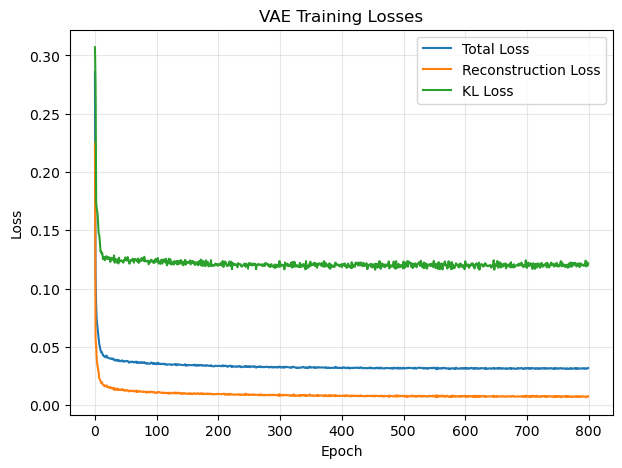

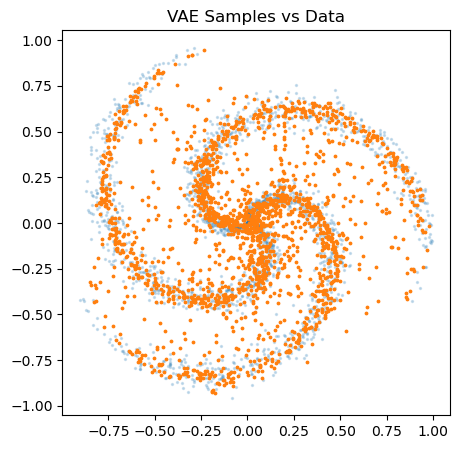

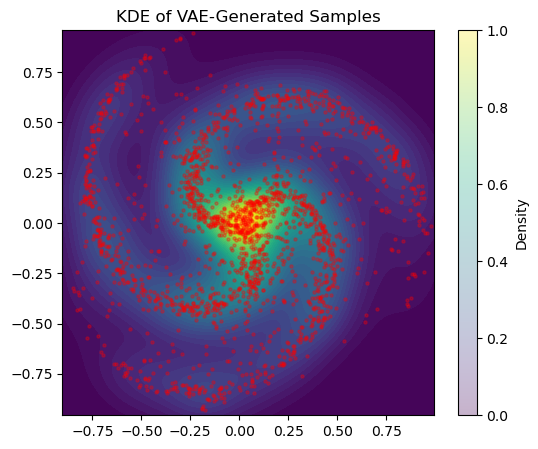


KDE Estimated Log-Likelihood (VAE): -0.6873



In [4]:
train_vae(pinwheel_loader, X_pinwheel, epochs=800, device = "cpu")


Training GAN...


Epochs: 100%|█████████████████████████████████| 800/800 [00:35<00:00, 22.40it/s]


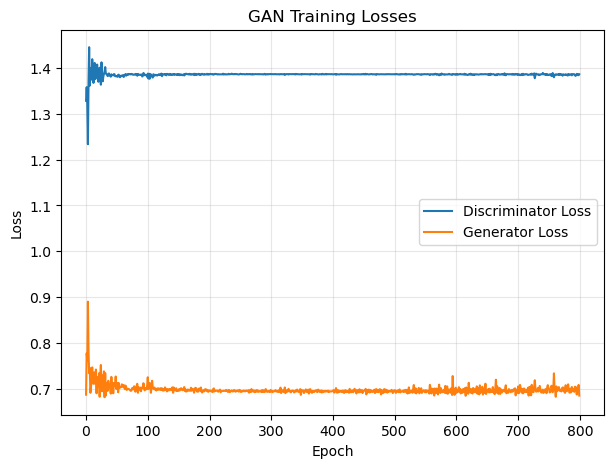

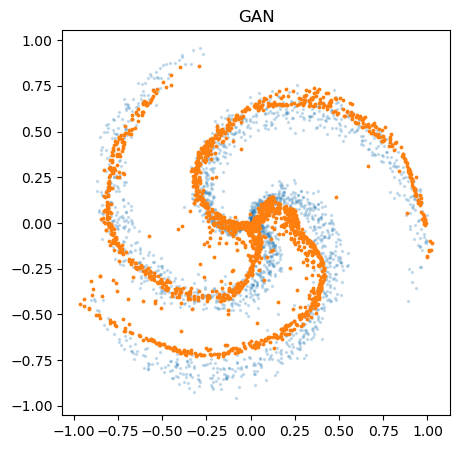

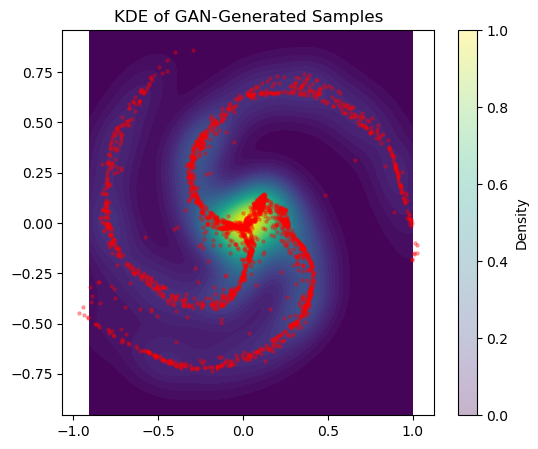


KDE Estimated Log-Likelihood (GAN): -0.6851



In [5]:
train_gan(pinwheel_loader, X_pinwheel, epochs=800, device="cpu")


Training VAE...


Epochs: 100%|███████████████████████████████| 1500/1500 [01:38<00:00, 15.29it/s]


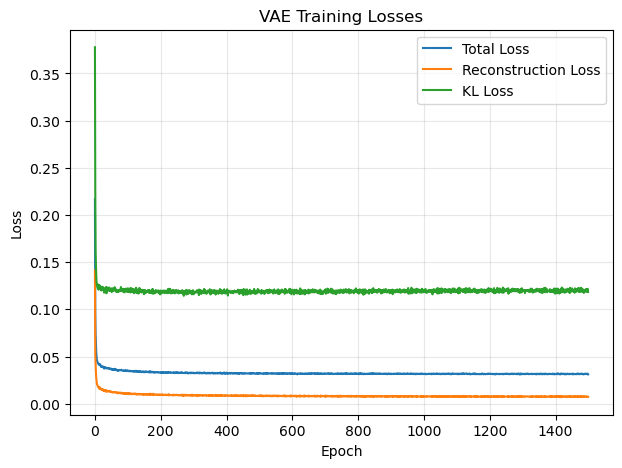

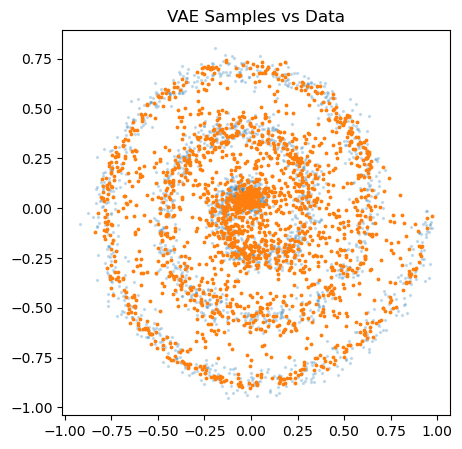

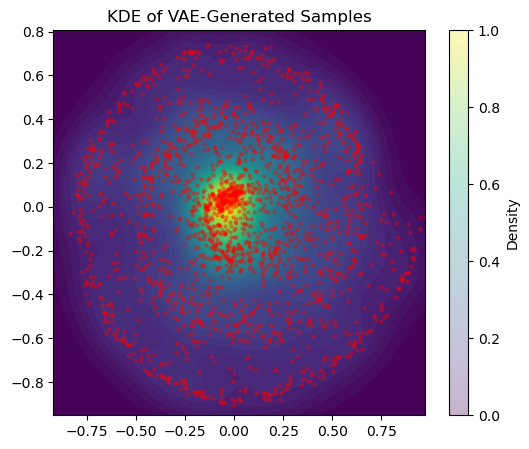


KDE Estimated Log-Likelihood (VAE): -0.7524



In [6]:
train_vae(spiral_loader, X_spiral, epochs=1500, device="cpu")


Training GAN...


Epochs: 100%|███████████████████████████████| 1200/1200 [00:51<00:00, 23.46it/s]


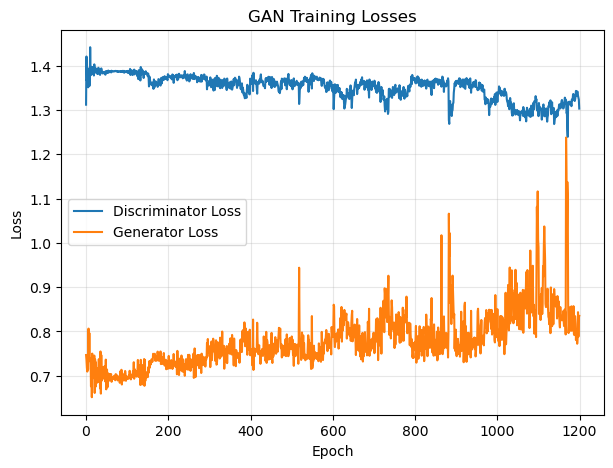

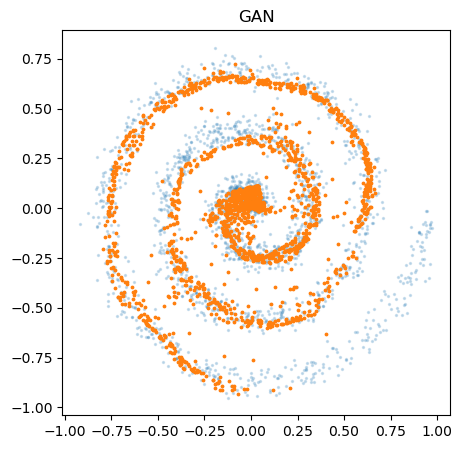

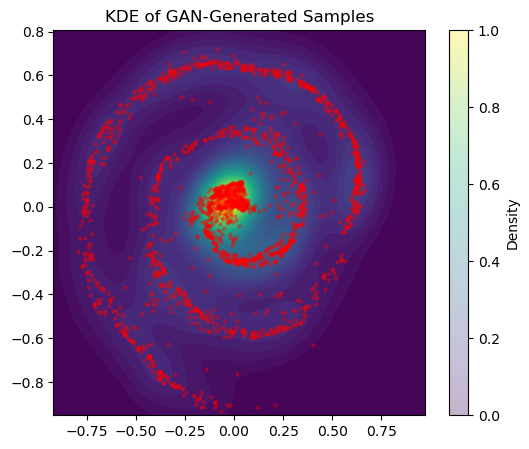


KDE Estimated Log-Likelihood (GAN): -1.0418



In [7]:
train_gan(spiral_loader, X_spiral, epochs=1200, device="cpu")


Training VAE...


Epochs: 100%|███████████████████████████████| 1000/1000 [01:11<00:00, 13.98it/s]


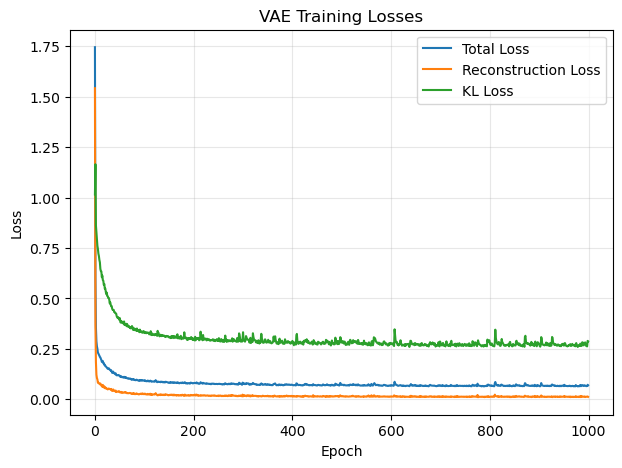

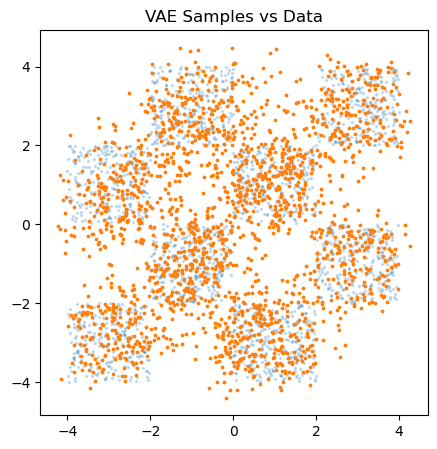

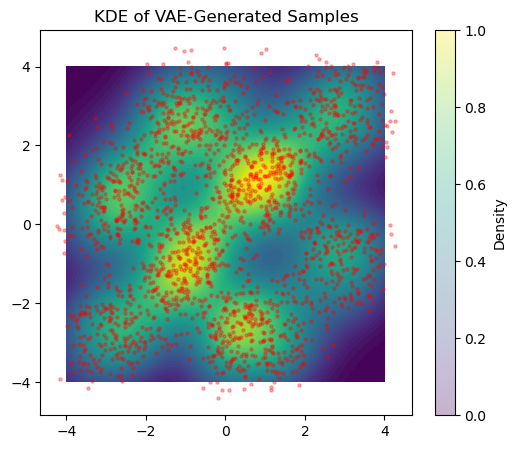


KDE Estimated Log-Likelihood (VAE): -4.0950



In [8]:
train_vae(checkerboard_loader, X_checkerboard, epochs=1000, device="cpu")


Training GAN...


Epochs: 100%|█████████████████████████████████| 650/650 [00:28<00:00, 22.64it/s]


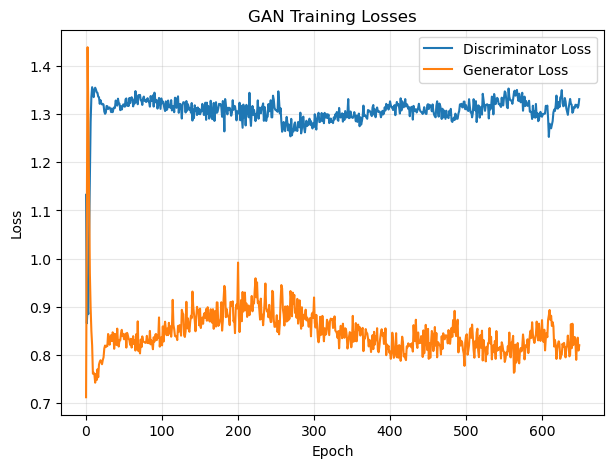

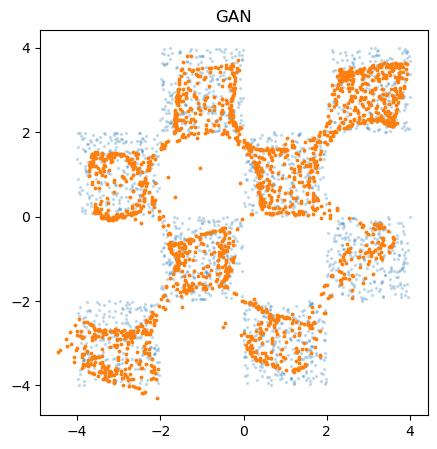

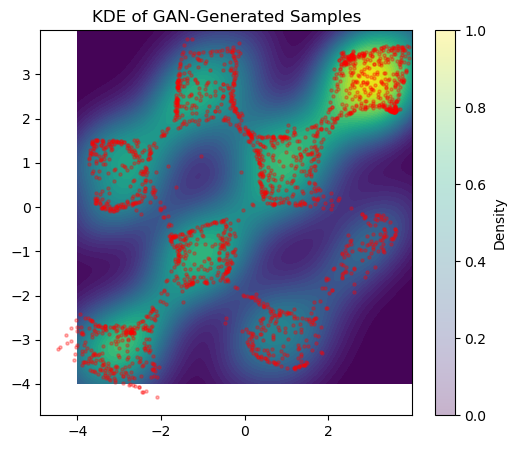


KDE Estimated Log-Likelihood (GAN): -4.0437



In [9]:
train_gan(checkerboard_loader, X_checkerboard, epochs=650, device="cpu")


Training VAE...


Epochs: 100%|█████████████████████████████████| 800/800 [00:53<00:00, 14.86it/s]


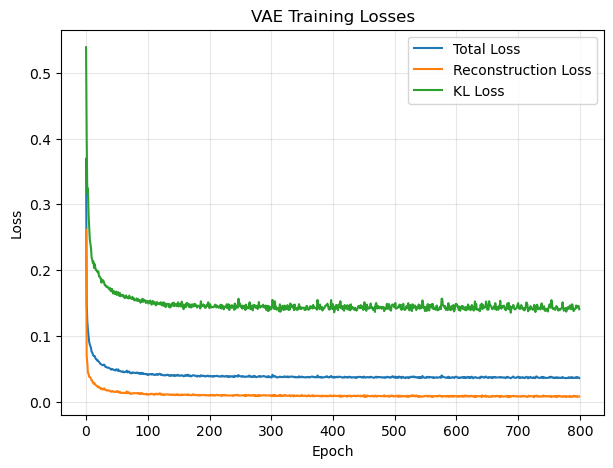

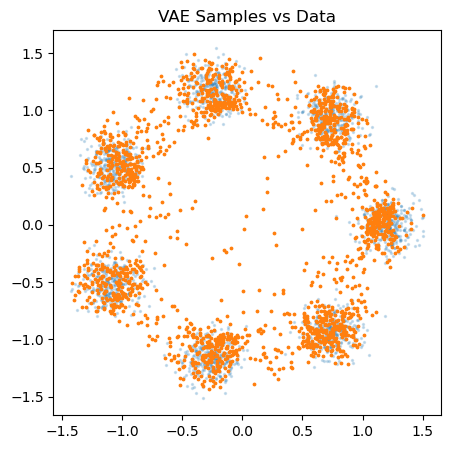

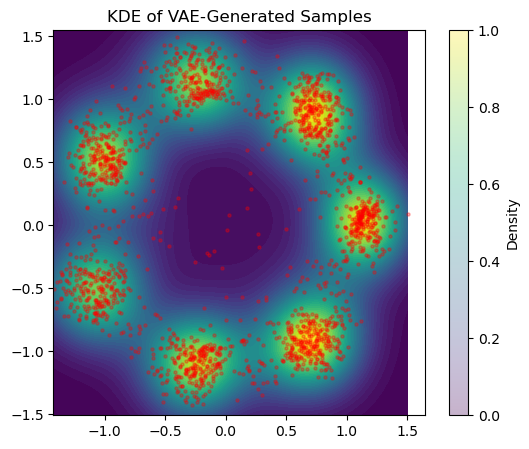


KDE Estimated Log-Likelihood (VAE): -1.4555



In [10]:
train_vae(gmm_loader, X_gmm, epochs=800, device="cpu")


Training GAN...


Epochs: 100%|█████████████████████████████████| 400/400 [00:16<00:00, 24.46it/s]


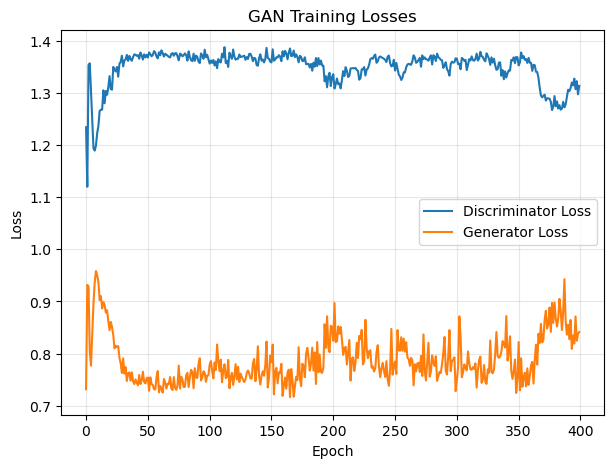

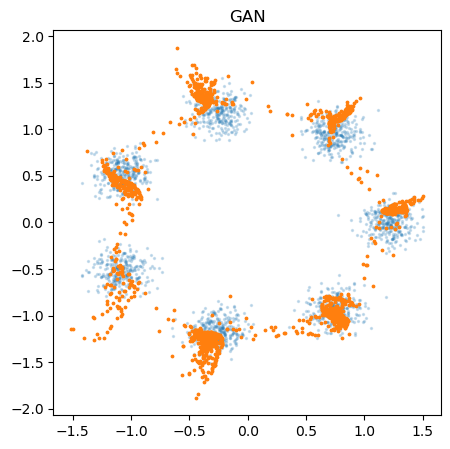

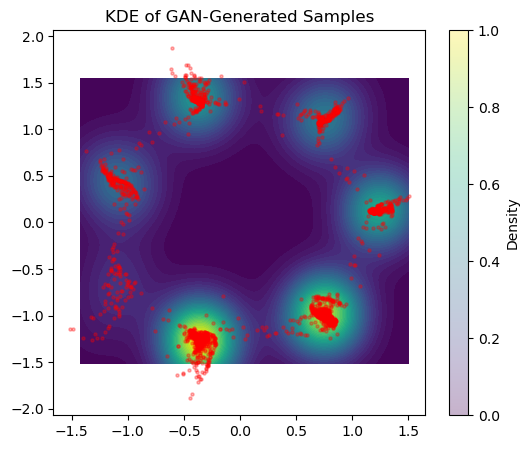


KDE Estimated Log-Likelihood (GAN): -1.6286



In [11]:
train_gan(gmm_loader, X_gmm, epochs=400, device="cpu")